## Travelling salesman

Code to try and find a solution to the travelling salesman problem on the globe using object-oriented simulated annealing

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as random

import csv
import smopy

#smopy tile server and basic options
smopy.TILE_SERVER = "http://tile.basemaps.cartocdn.com/light_all/{z}/{x}/{y}@2x.png"
smopy.TILE_SIZE = 512
worldmap = smopy.Map((0, -120, 65, 120), z=2)

In [2]:
class CityInfo:
    '''For cities for use in traveling salesman problem. Class stores name of city, country city is in, population, 
    lattitude and longitude'''
    def __init__(self, name, country, population, lat, lon):
        self.name = name
        self.country = country
        self.population = population
        self.lat = lat
        self.lon = lon
        
    
    
    
class SalesmanAnneal:
    '''Solves the TSM problem using a simulated annealing approach'''
    
    def __init__(self, cities, basemap=worldmap, T=-1, alpha=-1, stopping_T=-1, stopping_iter=-1 ):
        '''initialise the solver, loads city coordinates/names from arguments 
        cities argument should be a list generated from using the citysampling function'''
        self.cities = cities
                    
        self.basemap = basemap
                    
        self.initialguess = self.create_first_guess()
        self.currentgrid = np.copy(self.initialguess)
        
        # fill in empty sites of currentgrid with integers
        self.bestgrid = np.copy(self.currentgrid)
        
        #'fitness' or energy of solutions
        self.cur_fitness = self.fitness(self.currentgrid)
        self.initial_fitness = self.cur_fitness
        self.best_fitness = self.cur_fitness
        self.fitness_list = [self.cur_fitness]
        
        #annealing parameters (use defaults if not set...)
        self.T = 1.0E6 if T == -1 else T
        self.alpha = 0.999 if alpha == -1 else alpha
        self.stopping_temperature = 0.0001 if stopping_T == -1 else stopping_T
        self.stopping_iter = 100000 if stopping_iter == -1 else stopping_iter
        self.iteration = 1
    
                
    
    def create_first_guess(self):
        '''Random sequence of cities'''
        k = 0
        while k < 30:
            rand1 = random.randint(0, (len(self.cities)-1))
            rand2 = random.randint(0, (len(self.cities)-1))
            if rand1 != rand2:
                self.cities[rand1], self.cities[rand2] = self.cities[rand2], self.cities[rand1]
                k += 1
        return self.cities
            
    def print_cities_list(self):
        for k in range(len(self.cities)-1):
            print(self.cities[k].name)
        
    def city_swap(self, obj):
        rand1 = random.randint(0, (len(self.cities)-1))
        rand2 = random.randint(0, (len(self.cities)-1))
        if rand1 != rand2:
            obj[rand1], obj[rand2] = obj[rand2], obj[rand1]
        
    def fitness(self, obj):
        '''returns the "fitness", i.e. total RETURN path length.'''
        length = 0
        numcities = len(self.cities)
        for k in range(numcities-1):
            temp = gcd(obj[k].lat, obj[k].lon, obj[(k+1)%numcities].lat, obj[(k+1)%numcities].lon)
            length += temp
        return length
    
    def anneal(self):
        '''simulated annealing to find solution'''
        
        # loop until stopping conditions are met
        while self.T >= self.stopping_temperature and self.iteration < self.stopping_iter and self.best_fitness != 0:
            
            # generate a new candidate solution
            candidate = np.copy(self.currentgrid)
            self.city_swap(candidate)
            # accept the new candidate?
            self.accept(candidate)
            # update conditions
            self.T *= self.alpha
            self.iteration += 1
            
            # add current fitness to list
            self.fitness_list.append(self.cur_fitness)
            
    
    def accept(self, candidate):
        '''sets the acceptance rules for a new candidate'''
        candidate_fitness = self.fitness(candidate)
        
        # probability 1 for a lower energy candidate
        if candidate_fitness < self.cur_fitness:
            self.cur_fitness = candidate_fitness
            self.currentgrid = candidate
            
            #is the new candidate the best so far?
            if candidate_fitness < self.best_fitness:
                self.best_fitness = candidate_fitness
                self.bestgrid = candidate
        
        # otherwise accept with a probability given by the boltzmann-like term
        else:
            if np.random.random() < np.exp( - abs( candidate_fitness -self.cur_fitness) / self.T):
                self.cur_fitness = candidate_fitness
                self.currentgrid = candidate
                
    def print_grid(self):
        '''Outputs a pretty map showing a particular route'''
        numcities = len(self.bestgrid)
        fig, ax = plt.subplots(1,1, figsize = (10,10))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(False)
        ax.set_xlim(0, worldmap.w)
        ax.set_ylim(worldmap.h, 0)
        ax.axis('off')
        plt.tight_layout()
        ax.imshow(worldmap.img)
        px, py = [], []
        for i in range(0, (numcities-1)):
            plotx, ploty = worldmap.to_pixels(self.bestgrid[i].lat, self.bestgrid[i].lon)
            px.append(plotx)
            py.append(ploty)
        ax.plot(px, py, 'ro')
        for j in range(0, (numcities)):
            pathlat, pathlon = gcd_path(self.bestgrid[j].lat, self.bestgrid[j].lon, self.bestgrid[(j+1) % numcities].lat, self.bestgrid[(j+1) % numcities].lon, 10)
            pathx, pathy = worldmap.to_pixels(pathlat, pathlon)
            ax.plot(pathx, pathy, 'b.')
        fig.show()
    #other methods (e.g. GCD between two points, path route....)
    

In [3]:
def citysampling(numcities, param):
        with open('simplemaps-worldcities-basic.csv') as csvfile:
            readCSV = csv.reader(csvfile, delimiter=',')
            #skip the first line, which contains the legend
            next(readCSV)
            numlines = 7322  #sum(1 for line in readCSV)
            #print(numlines)
            chance_selected = numcities / numlines
            #print(chance_selected)
            cities = []
            '''select 30 random cities'''
            if param ==1:
                for row in readCSV:
                    if random.random() < chance_selected:
                        name = row[1]
                        latitude = float(row[2])
                        longitude = float(row[3])
                        pop = int(float((row[4]))) 
                        country = row[5]
                        citytemp = CityInfo(name,country,pop, latitude, longitude)
                        #print(citytemp.name)
                        if len(cities) < (numcities - 10):
                            cities.append(citytemp)
                        else:
                            break
                        '''select the 25 most populous cities'''
            elif param ==2:
                sort = sorted(readCSV, key=lambda readCSV:int(float(readCSV[4])), reverse = True)
                for row in sort:
                    name = row[1]
                    latitude = float(row[2])
                    longitude = float(row[3])
                    pop = int(float((row[4]))) 
                    country = row[5]
                    citytemp = CityInfo(name,country,pop, latitude, longitude)
                    if len(cities) < 25:
                        cities.append(citytemp)
                    else:
                        break
                    '''select all cities in Ireland'''
            elif param ==3:
                for row in readCSV:
                    if row[5] == 'Ireland':
                        name = row[1]
                        latitude = float(row[2])
                        longitude = float(row[3])
                        pop = int(float((row[4]))) 
                        country = row[5]
                        citytemp = CityInfo(name,country,pop, latitude, longitude)
                        #print(citytemp.name)
                        cities.append(citytemp)
            #print(cities)
            return cities

def gcd(alat, alon, blat, blon):
    lat1 = np.radians(alat)
    lat2 = np.radians(blat)
    lon1 = np.radians(alon)
    lon2 = np.radians(blon)

    dlon = lon2 - lon1 
    dlat = lat2 - lat1 

    hav = (np.sin(dlat/2))**2 + np.cos(lat1) * np.cos(lat2) * (np.sin(dlon/2))**2 
    c = 2 * np.arctan2( np.sqrt(hav), np.sqrt(1-hav) ) 
    return 6371* c 

def gcd_path(alat, alon, blat, blon, num):
    lat1 = np.radians(alat)
    lat2 = np.radians(blat)
    lon1 = np.radians(alon)
    lon2 = np.radians(blon)

    d=gcd(alat, alon, blat, blon)
    f= np.linspace(0, 1, num)

    delta = d / 6371
    alpha = np.sin((1-f)*delta) / np.sin(delta)
    beta = np.sin(f*delta) / np.sin(delta)

    x = alpha * np.cos(lat1) * np.cos(lon1) + beta * np.cos(lat2) * np.cos(lon2)
    y = alpha * np.cos(lat1) * np.sin(lon1) + beta * np.cos(lat2) * np.sin(lon2)
    z = alpha * np.sin(lat1) + beta * np.sin(lat2)

    newlats = (np.arctan2(z, np.sqrt(x**2 + y**2)))
    newlons = (np.arctan2(y, x))
    return np.degrees(newlats), (np.degrees(newlons) +540)%360 -180
            

In [4]:
test = citysampling(40, 1)
print(len(test))

testdist = gcd(test[0].lat, test[0].lon, test[1].lat, test[1].lon)
print(test[0].name, test[1].name)
print(testdist)

30
Mostaganem Medea
243.54024993740398


In [5]:
worldmap = smopy.Map((0, -120, 65, 120), z=2)
testing = SalesmanAnneal(test, worldmap)
testing.print_cities_list()
print(testing.fitness(testing.cities))

Drogheda
Zhuanghe
Kasur
Choybalsan
Zurich
Bafoulabe
Lovec
Hebi
Dease Lake
Mansehra
Pervouralsk
Gera
Norilsk
Djenne
Shilka
Huancayo
Medea
Cayambe
Mianyang
Bayamo
Oxford House
Tacna
Lorengau
Palatka
Kwinana
Mostaganem
Shebekino
Khabarovsk
Nairobi
236941.96722073236


In [6]:
testing.city_swap(testing.currentgrid)
print(testing.fitness(testing.currentgrid))

230213.09197913433


In [7]:
testing.anneal()

In [8]:
print(testing.fitness(testing.bestgrid))

80080.90798330729


In [9]:
print(testing.bestgrid[0].name)

Nairobi


<IPython.core.display.Javascript object>


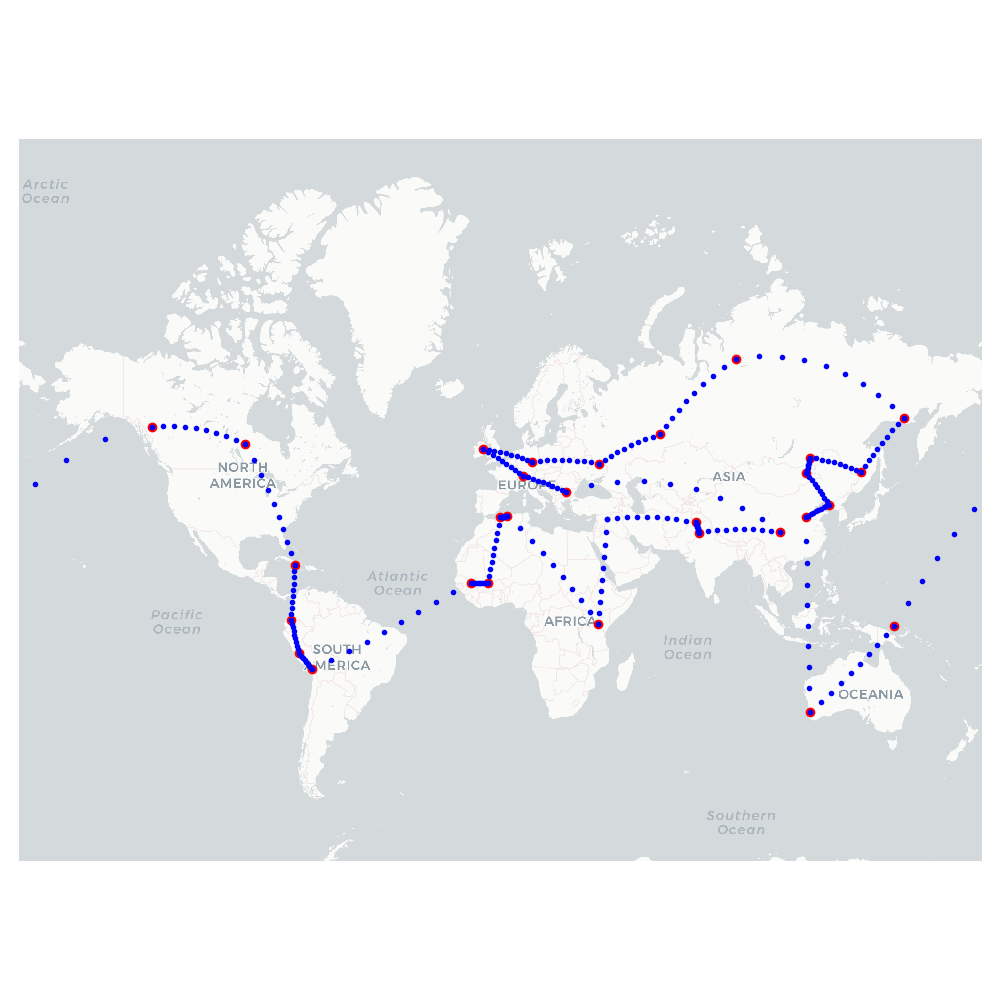

In [10]:
testing.print_grid()